In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
######## 读取数据 ########
sheet = pd.read_excel('data_input_auto/中国柴油实际消费量Trend-F=0.2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

In [4]:
sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4468 entries, 0 to 4467
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           4468 non-null   datetime64[ns]
 1   中国柴油实际消费量Trend/F=0.2           215 non-null    float64       
 2   中国10年期国债收益率同差                  4204 non-null   float64       
 3   企业中长期贷款+居民短期贷款同差/3MMA          207 non-null    float64       
 4   新增人民币存款/12MMA                  314 non-null    float64       
 5   M1同比/3MMA                      356 non-null    float64       
 6   固定资产投资完成额:基础设施建设投资(不含电力):累计同比  121 non-null    float64       
 7   A股基建指数                         3000 non-null   float64       
 8   水泥磨机运转率Trend/F=0.1             663 non-null    float64       
 9   上海新房平均销售价格同比                   96 non-null     float64       
 10  纯电动重卡月度渗透率/6MMA                39 non-null     float64       
 11  中国新能源重卡销量累计值转月值/6

In [5]:
sheet.tail()

,Date,中国柴油实际消费量Trend/F=0.2,中国10年期国债收益率同差,企业中长期贷款+居民短期贷款同差/3MMA,新增人民币存款/12MMA,M1同比/3MMA,固定资产投资完成额:基础设施建设投资(不含电力):累计同比,A股基建指数,水泥磨机运转率Trend/F=0.1,上海新房平均销售价格同比,纯电动重卡月度渗透率/6MMA,中国新能源重卡销量累计值转月值/6MMA,中国柴油实际消费量
4463,2025-05-08,NaN,-0.6622,NaN,NaN,NaN,NaN,1568.2656,33.115572,NaN,NaN,NaN,NaN
4464,2025-05-09,357.066989,-0.6799,NaN,NaN,NaN,NaN,1559.5076,NaN,NaN,NaN,NaN,418.3812
4465,2025-05-12,NaN,-0.6035,NaN,NaN,NaN,NaN,1573.1825,NaN,NaN,NaN,NaN,NaN
4466,2025-05-13,NaN,-0.6221,NaN,NaN,NaN,NaN,1577.9572,NaN,NaN,NaN,NaN,NaN
4467,2025-05-14,NaN,NaN,NaN,NaN,NaN,NaN,1577.9572,NaN,NaN,NaN,NaN,NaN


In [6]:
sheet =  sheet[['Date','中国柴油实际消费量Trend/F=0.2','中国柴油实际消费量']]
# 对两列进行线性插值填充空缺值
sheet['中国柴油实际消费量Trend/F=0.2'] = sheet['中国柴油实际消费量Trend/F=0.2'].interpolate(method='linear')
sheet['中国柴油实际消费量'] = sheet['中国柴油实际消费量'].interpolate(method='linear')

sheet = sheet.dropna()

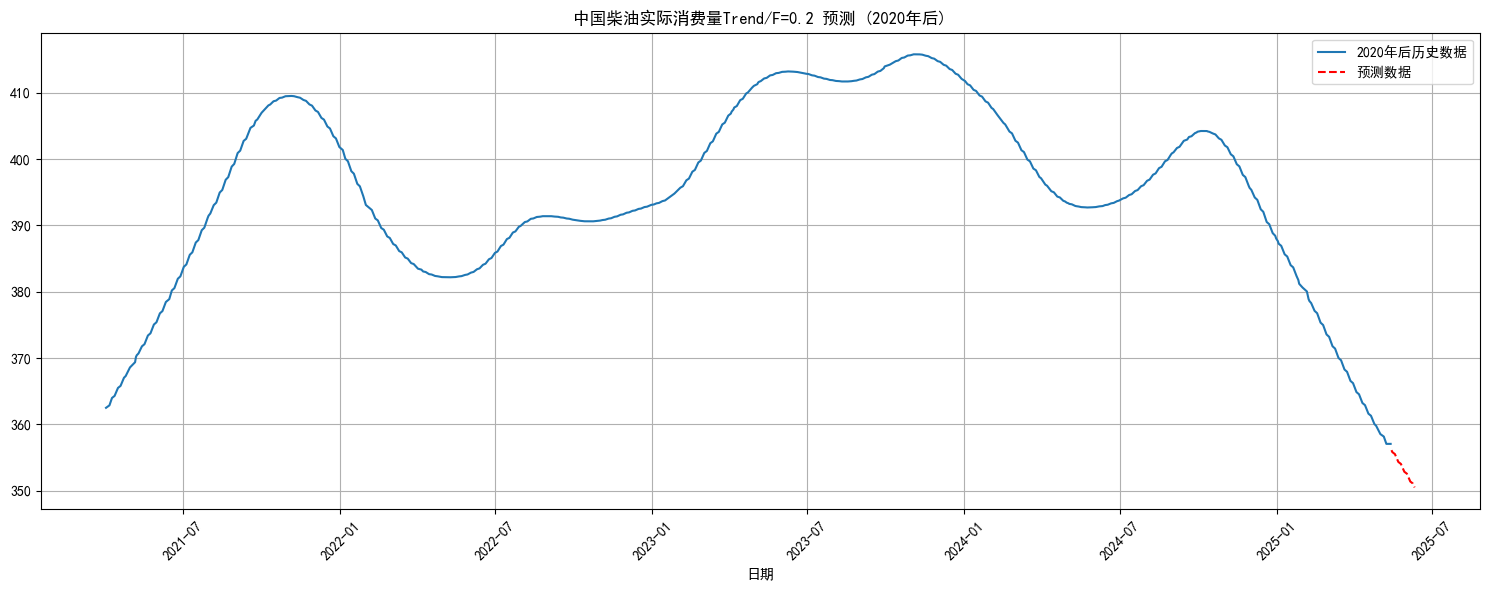

In [7]:

# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来20个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')  # 生成30天以确保获得20个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:20]  # 只保留工作日并取前20天

# 获取最后30个历史值用于线性回归
last_values = sheet['中国柴油实际消费量Trend/F=0.2'].tail(30).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来20个值
future_x = np.arange(len(last_values), len(last_values) + 20)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '中国柴油实际消费量Trend/F=0.2': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['中国柴油实际消费量Trend/F=0.2'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['中国柴油实际消费量Trend/F=0.2'], 'r--', label='预测数据')
plt.title('中国柴油实际消费量Trend/F=0.2 预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/中国柴油实际消费量Non-Trend-F0.2_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '中国柴油实际消费量Trend/F=0.2']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()
# 计算最终的
merged_df['中国柴油实际消费量'] = merged_df['预测值'] + merged_df['中国柴油实际消费量Trend/F=0.2']
merged_df.head() 

,Date,预测值,中国柴油实际消费量Trend/F=0.2,中国柴油实际消费量
865,2025-05-15,35.9719,356.117556,392.089456
866,2025-05-16,35.4685,355.822172,391.290672
867,2025-05-19,27.5006,355.526788,383.027388
868,2025-05-20,26.3005,355.231404,381.531904
869,2025-05-21,20.8829,354.936020,375.818920


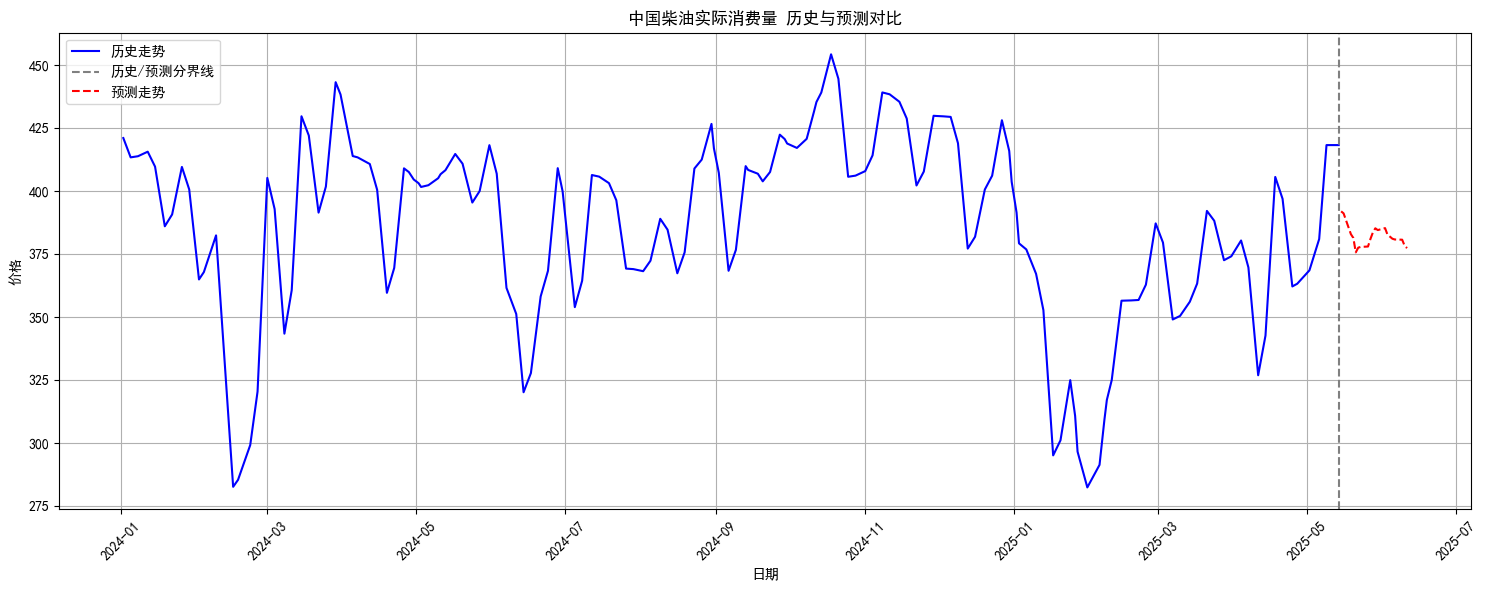

In [9]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']
# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['中国柴油实际消费量'], label='历史走势', color='blue')
# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')
# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['中国柴油实际消费量'], label='预测走势', color='red', linestyle='--')

plt.title('中国柴油实际消费量 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '中国柴油实际消费量']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '中国柴油实际消费量']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/中国柴油实际消费量_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,中国柴油实际消费量
629,2025/06/11,NaN,377.505061
628,2025/06/10,NaN,378.459845
627,2025/06/09,NaN,380.843829
626,2025/06/06,NaN,380.921513
625,2025/06/05,NaN,381.229197
...,...,...,...
4,2023/01/09,404.4583,NaN
3,2023/01/06,412.6683,NaN
2,2023/01/05,414.4047,NaN
1,2023/01/04,416.1411,NaN


In [11]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/中国柴油实际消费量_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,中国柴油实际消费量
0,2025/06/30,NaN,377.505061
1,2025/05/31,418.381200,384.658633
2,2025/04/30,366.546267,NaN
3,2025/03/31,374.262900,NaN
4,2025/02/28,387.314000,NaN


---

In [12]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '中国柴油实际消费量Trend/F=0.2']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/中国柴油实际消费量Trend-F=0.2_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend

,Date,实际值,中国柴油实际消费量Trend/F=0.2
629,2025/06/11,NaN,350.505261
628,2025/06/10,NaN,350.800645
627,2025/06/09,NaN,351.096029
626,2025/06/06,NaN,351.391413
625,2025/06/05,NaN,351.686797
...,...,...,...
4,2023/01/09,393.384088,NaN
3,2023/01/06,393.316404,NaN
2,2023/01/05,393.260208,NaN
1,2023/01/04,393.204011,NaN


In [13]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/中国柴油实际消费量Trend-F=0.2_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_trend.head()

,Date,实际值,中国柴油实际消费量Trend/F=0.2
0,2025/06/30,NaN,350.505261
1,2025/05/31,357.066989,352.868333
2,2025/04/30,359.042692,NaN
3,2025/03/31,366.218845,NaN
4,2025/02/28,373.557191,NaN


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国柴油实际消费量Trend/F=0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国柴油实际消费量"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国柴油实际消费量Trend/F=0.2"
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国柴油实际消费量"
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
